# This project is an exercise on using the Keras libraries to build a digit recognizer using the MNIST dataset. 
The was imported from the Kaggle Challenge : https://www.kaggle.com/c/digit-recognizer/data. 
I achieved this project as part of my neural network training.

Here I assumed the dataset is in the current working directory.

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


# 1. Import data
Import data and separate the predicted digit in the "label" column (integer between 0 and 9) and the pixels of each image. Each image is 28 pixels by 28 pixels, which means 784 pixels in total. 

In [6]:
train=pd.read_csv('train.csv')

Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

In [8]:
test=pd.read_csv('test.csv')
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(X_train.shape)

(42000, 784)


# 2. Preprocessing

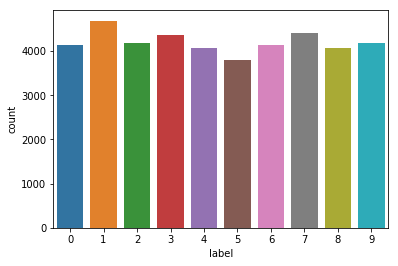

In [10]:
#Counts occurences of each digit in the training set
g = sns.countplot(Y_train)



We observe that the dataset is quite evenly distributed, with relatively the same occurence for each number.This means we can continue our work without having to downsize the dataset.

In [11]:
#Check for null or missing values
X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalization: We normalize the pixel values for both the training and test sets

In [12]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0


## Reshape the data in 3 dimensions (h: 28px, w: 28px, canal: 1)

In [13]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)



## One hot encoding of digit prediction.

In [14]:
Y_train = to_categorical(Y_train, num_classes = 10)



Split training and validation set

In [15]:
#Set the random seed
random_seed=2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

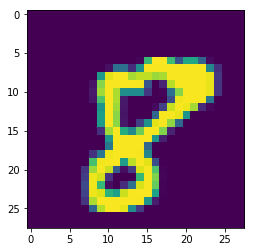

In [16]:
#Display one of the digits
g = plt.imshow(X_train[520][:,:,0])

In [17]:
X_train[0].shape

(28, 28, 1)

# 3. The Model
## Here the model we used is a CNN with the following architecture : In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

In [18]:
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))



## Set the optimizer and annealer

In [19]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)



In [20]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



In [22]:
epochs = 1 #Increasing the epoch number increases the accuracy
batch_size = 86

## Data augmentation

In [23]:
# We use data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)



In [25]:
# Fit the model
#64 and 64 (first two:) gives 0.8616 and 0.9836
#128 and 128 (same) gives 0.87 and 0.9833
#Globally increasing the number of layers increases the accuracy but slows down the computation 
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])



Epoch 1/1
 - 1426s - loss: 0.3819 - acc: 0.8769 - val_loss: 0.0843 - val_acc: 0.9760


# 4. Evaluate the model : 
## Confusion matrix

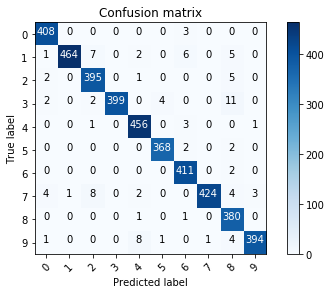

In [26]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Display errors 
We check our prediction by having a look at the errors, to get a sense of the righteousness of the model.
To achieve this we defined the display_errors function below :

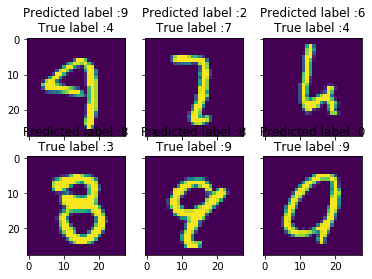

In [27]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

From this error analysis, we observe that the digits for which our digit recognizer fails are not evident to predict. To the human eye, it can be unclear whether the second digit is a 2 or a 7. Same for the first one. We can conclude that our model is pretty accurate and does not predict results that are too aberrant.

# 5. Prediction
We finally predict the results for the test set. We obtained an accuracy of 0.97928. 
Further improvements could be made by tuning the convolution layers (# filters), test other model configurations, tuning the parameters, add more epochs etc. For computing time reasons, we consider this result satisfying for our expectations.

In [29]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [30]:
#Submission
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_predicted.csv",index=False)